***
# **HMC Labs - TimeSeries Analyzer** 

<img style="float: left; padding-right: 80px; padding-left: 5px;" src="img/logo_hmc.png" width="250px" align=”left” >

In the laboratory of **HMC time-series** we will perform the following points:
   * Configure the libraries and the dependecies of the laboratory;
   * Read the configuration file of the laboratory;
   * Read the static datasets of terrain, river networks and outlet sections;
   * Select the 'time run' and the 'outlet section' to perform the time-series analysis;
   * Read the dynamic datasets of the time-series;
   * Plot the position of the analyzed outlet section;
   * Plot the time-series of discharge (for different run types) and the time-series of the hmc average forcings.    


## **Import libraries and dependencies**

In [77]:
%matplotlib inline
%matplotlib widget


# Libraries
import logging
import os
import sys
from argparse import ArgumentParser

from library.common.lib_info_args import logger_name, logger_format
from library.common.lib_utils_logging import set_logging_file

from library.common.lib_data_io_json import read_file_settings
from library.common.lib_data_io_generic import define_file_path_analyzer, define_file_time, filter_file_time, select_file_time, \
    define_file_obj, define_file_variables, \
    get_path_root, get_path_home, set_info_mode

from library.common.lib_data_geo_ascii import read_data_grid
from library.common.lib_data_geo_shapefile import read_data_section, find_data_section, \
    create_tag_section, search_tag_section, validate_tag_section

from library.common.lib_data_io_netcdf import select_collections_var
from library.common.lib_data_organizer import wrap_ts, adjust_ts, wrap_file

from library.common.lib_graph_ts_utils import check_ts_workspace
from library.common.lib_graph_ts_obs import plot_ts_forcing_obs, plot_ts_discharge_obs
from library.common.lib_graph_ts_nwp import plot_ts_discharge_nwp_deterministic, plot_ts_discharge_nwp_probabilistic
from library.common.lib_graph_map import plot_map_terrain

from library.common.lib_utils_time import create_time_range

# Logging
logging.getLogger("fiona").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("pandas").setLevel(logging.WARNING)

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Define configuration file
file_name_settings="fp_labs_analyzer_hmc_timeseries.json"

# Info
print(' ==> Libraries loaded')

 ==> Libraries loaded


### **Configure the flood-proofs laboratory**
#### Load the configuration file

In [78]:
# Read data from settings algorithm file
obj_settings = read_file_settings(file_name_settings)

# Set algorithm logging
set_logging_file(
    logger_name=logger_name,
    logger_formatter=logger_format,
    logger_file=os.path.join(obj_settings['log']['folder_name'], obj_settings['log']['file_name']))

# Get root path of the lab
file_root_path = os.getcwd()

# Info
print(' ==> Lab reference path: "' + file_root_path + '"')
print(' ==> Read settings information... DONE')

 ==> Lab reference path: "/home/fabio/Documents/Work_Area/Code_Development/Workspace/PyCharm_Notebook/fp-labs-hmc-master"
 ==> Read settings information... DONE


####  Create settings object(s) and define settings information

In [79]:
# Define objects
obj_generic = obj_settings['generic']
obj_variables_section = obj_settings['variables']['section']
obj_variables_domain = obj_settings['variables']['domain']
obj_template_path = obj_settings['template']['path']
obj_template_geo = obj_settings['template']['geo']
obj_template_time = obj_settings['template']['time']
obj_data_static = obj_settings['data']['static']
obj_data_dynamic_source = obj_settings['data']['dynamic']['source']
obj_data_dynamic_destination_workspace = obj_settings['data']['dynamic']['destination']
obj_data_dynamic_destination_plot = obj_settings['data']['dynamic']['plot']

# Info
print(' ==> Create settings objects ... DONE')

 ==> Create settings objects ... DONE


In [80]:
# Define mode and geographical information
info_mode, info_domain_name, info_basin_name, info_section_name = set_info_mode(obj_settings['generic'])

# Info
print(' ==> Lab mode: "' + info_mode + '"')
print(' ==> Define geographical information ... DONE')

 ==> Lab mode: "cmd"
 ==> Define geographical information ... DONE


In [81]:
# Define case-study information
info_time_analysis = obj_settings['case_study']['time_analysis']
info_time_start = obj_settings['case_study']['time_start']
info_time_end = obj_settings['case_study']['time_end']
info_time_period_left = obj_settings['case_study']['time_period_left']
info_time_period_right = obj_settings['case_study']['time_period_right']
info_description_analysis = obj_settings['case_study']['description']

# Define analysis time range
info_time_db_analysis_period, info_time_str_analysis_period = create_time_range(
    time_analysis=info_time_analysis, time_start=info_time_start, time_end=info_time_end,
    time_analysis_left_period=info_time_period_left, time_analysis_right_period=info_time_period_right)

# Info
print(' ==> Define case-study information ... DONE')

 INFO --> Time period is defined from "2022-11-21 15:00" to "2022-11-13 10:00"
 ==> Define case-study information ... DONE


#### Define the static and dynamic root path(s)

In [82]:
# Define static and dynamic path root
file_path_home = get_path_home(obj_generic['path_home'])
file_path_root_static = get_path_root(obj_generic['path_root_data_static'], home_path_string=file_path_home)
file_path_root_dynamic_source = get_path_root(
    obj_generic['path_root_data_dynamic_source'], home_path_string=file_path_home)
file_path_root_dynamic_destination_workspace = get_path_root(
    obj_generic['path_root_data_dynamic_destination_workspace'], home_path_string=file_path_home)
file_path_root_dynamic_destination_plot = get_path_root(
    obj_generic['path_root_data_dynamic_destination_plot'], home_path_string=file_path_home)

# Info
print(' ==> Define settings root path(s) ... DONE')

 ==> Define settings root path(s) ... DONE


### **Static Datasets Objects**
#### Define the static path(s)

In [83]:
# Define file static path(s)
obj_filled_path = dict.fromkeys(list(obj_template_path.keys()), file_path_root_static)

file_path_dset_static = define_file_path_analyzer(
    obj_data_static, path_template_raw=obj_template_path, path_template_values=obj_filled_path,
    tag_file_time=None)[0]

# Read sections shapefile
dframe_section = read_data_section(file_path_dset_static['sections'])
# Info
print(' ==> Define static path(s) ... DONE')

 ==> Define static path(s) ... DONE


#### Create the static object map

In [84]:
# Read terrain datasets
darray_terrain = read_data_grid(file_path_dset_static['terrain'], var_limit_min=0, var_limit_max=None)
# Read river network datasets
darray_river_network = read_data_grid(file_path_dset_static['river_network'], var_limit_min=0, var_limit_max=1)
# Info
print(' ==> Define map information ... DONE')

 ==> Define map information ... DONE


#### Create the static object section

In [85]:
# Read sections shapefile
dframe_section = read_data_section(file_path_dset_static['sections'])

# Info
dframe_section.head(5)

,hmc_idx_x,hmc_idx_y,latitude,longitude,basin_name,section_name,section_code,section_drained_area,section_discharge_thr_alert,section_discharge_thr_alarm
0,72,286,43.907555,12.897710,Foglia,Foglia3,1126,698.7,197.1,348.75
1,92,241,43.849812,12.764225,Foglia,Montecchio,2821,605.6,72.0,110.00
2,106,155,43.808586,12.512582,Foglia,Bronzo,1158,238.3,50.0,105.00
3,95,284,43.839886,12.894738,Arzilla,Arzilla,1052,49.0,10.0,18.00
4,101,335,43.826328,13.053796,Metauro,FoceMetauro,2673,1413.7,300.0,600.00


In [86]:
# Create section object(s)
info_section_list, info_section_dict = create_tag_section(dframe_section)

In [87]:
# Display available outlet sections
info_section_select = widgets.Dropdown(options=info_section_list, description='Sections', disabled=False, rows=5)
display(info_section_select)   

Dropdown(description='Sections', options=('Arzilla:Arzilla', 'Arzilla:FoceArzilla', 'Aso:Aso', 'Aso:Rubbianell…

In [88]:
# Parser the selection from the scroll menu
info_section_value = info_section_select.value

# Validate section and basin info
info_basin_name, info_section_name = validate_tag_section(
    info_section_value, basin_name=info_basin_name, section_name=info_section_name)

# Get domain, section and time information
info_section_attrs = find_data_section(
    dframe_section, section_name=info_section_name, basin_name=info_basin_name)

# Create geographical object
obj_filled_geo = {'section_name': info_section_name, 'basin_name': info_basin_name, 'domain_name': info_domain_name}

# Info
print(' ==> Section Name: ' + obj_filled_geo['section_name'] + ' -- Basin Name: ' + obj_filled_geo['basin_name'] )
print(' ==> Define section information ... DONE')

 WARNING ===> Basin and section name are defined by the json and the user input
 WARNING ===> String are different. The user input selection will be considered.
 ==> Section Name: Arzilla -- Basin Name: Arzilla
 ==> Define section information ... DONE


### **Dynamic Datasets Objects**
####  Define dataframe variable(s)

In [89]:
# Define variables
run_variables_section = define_file_variables(obj_variables_section, obj_filled_geo)
run_variables_domain = define_file_variables(obj_variables_domain, obj_filled_geo)

# Info
print(' ==> Define dynamic sections and domain variable(s) ... DONE')

 ==> Define dynamic sections and domain variable(s) ... DONE


#### Define the dynamic path(s)

In [90]:
# Dynamic source settings
obj_filled_path = dict.fromkeys(list(obj_template_path.keys()), file_path_root_dynamic_source)

# Get time db and reference
info_time_db_dynamic_source_generic, info_time_ref_dynamic_source_generic = define_file_time(
    obj_data_dynamic_source,
    geo_template_raw=obj_template_path, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values=None,
    path_template_raw=obj_template_path, path_template_values=obj_filled_path)

# Filter time according to the analysis period (routine for interactive mode)
info_time_db_dynamic_source_filtered, info_time_list_dynamic_source_filtered = filter_file_time(
    info_time_db_dynamic_source_generic, info_time_db_analysis_period)

# Info
print(' ==> Define dynamic time variable(s) ... DONE')

 ===> Time analysis and time datasets for "nwp_probabilistic_ecmwf0100" run does not have common time(s)
 ==> Define dynamic time variable(s) ... DONE


* **Select time of "weather_station" run**

In [91]:
# Display available run(s)
run_tag = 'weather_stations'; 
info_time_list = info_time_db_dynamic_source_filtered[run_tag]
info_time_select = widgets.Dropdown(options=info_time_list, description='TimeRun', disabled=False, rows=10)
display(info_time_select)  

Dropdown(description='TimeRun', options=(Timestamp('2022-11-17 13:00:00', freq='-1H'), Timestamp('2022-11-17 1…

In [18]:
# Parser the selection from the scroll menu
info_time_value = info_time_select.value
info_time_dict_ws = {run_tag: info_time_value}

# Info
print(' ==> Run: ' + run_tag + ' -- Time Select: ' + str(info_time_value))

 ==> Run: weather_stations -- Time Select: 2022-09-16 12:00:00


* **Select time of "nwp_deterministic_lami2i" run**

In [19]:
# Display available run(s)
run_tag = 'nwp_deterministic_lami2i'; 
info_time_list = info_time_db_dynamic_source_filtered[run_tag]
info_time_select = widgets.Dropdown(options=info_time_list, description='TimeRun', disabled=False, rows=10)
display(info_time_select)  

Dropdown(description='TimeRun', options=(Timestamp('2022-09-16 04:00:00'), Timestamp('2022-09-15 04:00:00')), …

In [20]:
# Parser the selection from the scroll menu
info_time_value = info_time_select.value
info_time_dict_nwp_det_lami2i = {run_tag: info_time_value}

# Info
print(' ==> Run: ' + run_tag + ' -- Time Select: ' + str(info_time_value))

 ==> Run: nwp_deterministic_lami2i -- Time Select: 2022-09-16 04:00:00


* **Select time of "nwp_probabilistic_lami2i" run**

In [21]:
# Display available run(s)
run_tag = 'nwp_probabilistic_lami2i'; 
info_time_list = info_time_db_dynamic_source_filtered[run_tag]
info_time_select = widgets.Dropdown(options=info_time_list, description='TimeRun', disabled=False, rows=10)
display(info_time_select)  

Dropdown(description='TimeRun', options=(Timestamp('2022-09-16 04:00:00'), Timestamp('2022-09-15 04:00:00')), …

In [22]:
# Parser the selection from the scroll menu
info_time_value = info_time_select.value
info_time_dict_nwp_prob_lami2i = {run_tag: info_time_value}

# Info
print(' ==> Run: ' + run_tag + ' -- Time Select: ' + str(info_time_value))

 ==> Run: nwp_probabilistic_lami2i -- Time Select: 2022-09-16 04:00:00


* **Select time of "nwp_deterministic_ecmwf0100" run**

In [23]:
# Display available run(s)
run_tag = 'nwp_deterministic_ecmwf0100'; 
info_time_list = info_time_db_dynamic_source_filtered[run_tag]
info_time_select = widgets.Dropdown(options=info_time_list, description='TimeRun', disabled=False, rows=10)
display(info_time_select)  

Dropdown(description='TimeRun', options=(Timestamp('2022-09-16 06:00:00', freq='-1D'), Timestamp('2022-09-15 0…

In [24]:
# Parser the selection from the scroll menu
info_time_value = info_time_select.value
info_time_dict_nwp_det_ecmwf0100 = {run_tag: info_time_value}

# Info
print(' ==> Run: ' + run_tag + ' -- Time Select: ' + str(info_time_value))

 ==> Run: nwp_deterministic_ecmwf0100 -- Time Select: 2022-09-16 06:00:00


* **Select time of "nwp_probabilistic_ecmwf0100" run**

In [25]:
# Display available run(s)
run_tag = 'nwp_probabilistic_ecmwf0100'; 
info_time_list = info_time_db_dynamic_source_filtered[run_tag]
info_time_select = widgets.Dropdown(options=info_time_list, description='TimeRun', disabled=False, rows=10)
display(info_time_select) 

Dropdown(description='TimeRun', options=(Timestamp('2022-09-16 06:00:00'), Timestamp('2022-09-15 06:00:00')), …

In [26]:
# Parser the selection from the scroll menu
info_time_value = info_time_select.value
info_time_dict_nwp_prob_ecmwf0100 = {run_tag: info_time_value}

# Info
print(' ==> Run: ' + run_tag + ' -- Time Select: ' + str(info_time_value))

 ==> Run: nwp_probabilistic_ecmwf0100 -- Time Select: 2022-09-16 06:00:00


In [27]:
# Join the selected time reference in a common workspace
info_time_dynamic_source_selected = {**info_time_dict_ws, **info_time_dict_nwp_det_lami2i, **info_time_dict_nwp_prob_lami2i, 
                                     **info_time_dict_nwp_det_ecmwf0100, **info_time_dict_nwp_prob_ecmwf0100}
# Info
for key, value in info_time_dynamic_source_selected.items():
    print('run_name: ' + str(key) + ' - time: ' + str(value))
print(' ==> Define dynamic time source ... DONE')

run_name: weather_stations - time: 2022-09-16 12:00:00
run_name: nwp_deterministic_lami2i - time: 2022-09-16 04:00:00
run_name: nwp_probabilistic_lami2i - time: 2022-09-16 04:00:00
run_name: nwp_deterministic_ecmwf0100 - time: 2022-09-16 06:00:00
run_name: nwp_probabilistic_ecmwf0100 - time: 2022-09-16 06:00:00
 ==> Define dynamic time source ... DONE


In [29]:
# Define dynamic source folder(s)
file_path_dynamic_source = define_file_path_analyzer(
    obj_data_dynamic_source, tag_file_time='time_dataset',
    geo_template_raw=obj_template_path, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_dataset': info_time_dynamic_source_selected},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path)[0]

info_dynamic_source = define_file_obj(obj_data_dynamic_source, tag_file_obj='info')
flags_dynamic_source = define_file_obj(obj_data_dynamic_source, tag_file_obj='flags')

# Info
print(' ==> Define dynamic source path(s) ... DONE')

 ==> Define dynamic source path(s) ... DONE


In [31]:
# Define dynamic section workspace destination folder(s)
obj_filled_path = dict.fromkeys(list(obj_template_path.keys()), file_path_root_dynamic_destination_workspace)
file_path_dset_dynamic_destination_workspace_section = define_file_path_analyzer(
    obj_data_dynamic_destination_workspace, tag_file_time='time_reference',
    geo_template_raw=obj_template_geo, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': info_time_analysis},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path,
    tag_group='section_time_series')[0]

# Define dynamic domain workspace destination folder(s)
file_path_dset_dynamic_destination_workspace_domain = define_file_path_analyzer(
    obj_data_dynamic_destination_workspace, tag_file_time='time_reference',
    geo_template_raw=obj_template_geo, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': info_time_analysis},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path,
    tag_group='domain_time_series')[0]

# Info
print(' ==> Define dynamic destination path(s) ... DONE')

 ==> Define dynamic destination path(s) ... DONE


In [33]:
# Define dynamic section plot destination folder(s)
obj_filled_path = dict.fromkeys(list(obj_template_path.keys()), file_path_root_dynamic_destination_plot)
file_path_dset_dynamic_destination_plot_section, file_act_dset_dynamic_destination_plot_section = define_file_path_analyzer(
    obj_data_dynamic_destination_plot, tag_file_time='time_reference',
    geo_template_raw=obj_template_geo, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': info_time_analysis},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path,
    tag_group='section_time_series')
# Define dynamic domain plot destination folder(s)
file_path_dset_dynamic_destination_plot_domain, file_act_dset_dynamic_destination_plot_domain = define_file_path_analyzer(
    obj_data_dynamic_destination_plot, tag_file_time='time_reference',
    geo_template_raw=obj_template_geo, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': info_time_analysis},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path,
    tag_group='domain_time_series')

# Info
print(' ==> Define dynamic plot path(s) ... DONE')

 ==> Define dynamic plot path(s) ... DONE


#### Configure and get run datasets
* Configure and get time-series of **"domain average forcings"**

In [34]:
# Configure and get time-series of domain forcing (DomainAverate tag)
run_tag = 'weather_stations'

run_file_path_source = file_path_dynamic_source[run_tag]
run_file_path_destination_workspace = file_path_dset_dynamic_destination_workspace_domain[run_tag]
run_info = {**info_dynamic_source[run_tag]}
run_flags = flags_dynamic_source[run_tag]

run_file_path_source = wrap_file(
    run_file_path_source, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='data')

run_file_path_destination_workspace = wrap_file(
    run_file_path_destination_workspace, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='workspace')

dframe_domain_forcing_raw = wrap_ts(
    run_file_path_source, run_file_path_destination_workspace,
    file_run=run_tag, file_description='domain',
    dict_info=run_info, dict_flags=run_flags, dict_variables=run_variables_domain)

# Info
print(' ==> Configure and get time-series of "' + run_tag + '" forcings ... DONE')

 INFO --> Wrap "weather_stations" datasets of "domain" ... 
 INFO ---> Organize time series collections ... 
 INFO ----> Get collections file "hmc.collections.202209161200.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209161200.nc" ... DONE
 INFO ----> Create collections dataframe ... 
 INFO ----> Create collections dataframe ... DONE
 INFO ---> Organize time series collections ... DONE
 INFO --> Wrap "weather_stations" datasets of "domain" ... DONE
 ==> Configure and get time-series of "weather_stations" forcings ... DONE


* Configure and get time-series of **"weather_stations"** run

In [35]:
# WEATHER STATIONS
run_tag = 'weather_stations'

run_file_path_source = file_path_dynamic_source[run_tag]
run_file_path_destination_workspace = file_path_dset_dynamic_destination_workspace_section[run_tag]
run_info = {**info_dynamic_source[run_tag], **info_section_attrs}
run_flags = flags_dynamic_source[run_tag]

run_file_path_source = wrap_file(
    run_file_path_source, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='data')

run_file_path_destination_workspace = wrap_file(
    run_file_path_destination_workspace, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='workspace')

dframe_ws_raw = wrap_ts(
    run_file_path_source, run_file_path_destination_workspace,
    file_run=run_tag, file_description='section',
    dict_info=run_info, dict_flags=run_flags, dict_variables=run_variables_section)

# Info
print(' ==> Configure and get time-series of "' + run_tag + '" run ... DONE')

 INFO --> Wrap "weather_stations" datasets of "section" ... 
 INFO ---> Organize time series collections ... 
 INFO ----> Get collections file "hmc.collections.202209161200.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209161200.nc" ... DONE
 INFO ----> Create collections dataframe ... 
 INFO ----> Create collections dataframe ... DONE
 INFO ---> Organize time series collections ... DONE
 INFO --> Wrap "weather_stations" datasets of "section" ... DONE
 ==> Configure and get time-series of "weather_stations" run ... DONE


* Configure and get time-series of **"nwp_deterministic_lami2i"** run

In [36]:
# NWP LAMI-2I DETERMINISTIC
run_tag = 'nwp_deterministic_lami2i'

run_file_path_source = file_path_dynamic_source[run_tag]
run_file_path_destination_workspace = file_path_dset_dynamic_destination_workspace_section[run_tag]
run_info = {**info_dynamic_source[run_tag], **info_section_attrs}
run_flags = flags_dynamic_source[run_tag]

run_file_path_source = wrap_file(
    run_file_path_source, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='data')

run_file_path_destination_workspace = wrap_file(
    run_file_path_destination_workspace, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='workspace')

dframe_nwp_lami2i_det_raw = wrap_ts(
    run_file_path_source, run_file_path_destination_workspace,
    file_run=run_tag, file_description='section',
    dict_info=run_info, dict_flags=run_flags, dict_variables=run_variables_section)

# Info
print(' ==> Configure and get time-series of "' + run_tag + '" run ... DONE')

 INFO --> Wrap "nwp_deterministic_lami2i" datasets of "section" ... 
 INFO ---> Organize time series collections ... 
 INFO ----> Get collections file "hmc.collections.202209160400.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160400.nc" ... DONE
 INFO ----> Create collections dataframe ... 
 INFO ----> Create collections dataframe ... DONE
 INFO ---> Organize time series collections ... DONE
 INFO --> Wrap "nwp_deterministic_lami2i" datasets of "section" ... DONE
 ==> Configure and get time-series of "nwp_deterministic_lami2i" run ... DONE


* Configure and get time-series of **"nwp_probabilistic_lami2i"** run

In [37]:
# NWP LAMI-2I PROBABILISTIC
run_tag = 'nwp_probabilistic_lami2i'

run_file_path_source = file_path_dynamic_source[run_tag]
run_file_path_destination_workspace = file_path_dset_dynamic_destination_workspace_section[run_tag]
run_info = {**info_dynamic_source[run_tag], **info_section_attrs}
run_flags = flags_dynamic_source[run_tag]

run_file_path_source = wrap_file(
    run_file_path_source, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='data')

run_file_path_destination_workspace = wrap_file(
    run_file_path_destination_workspace, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='workspace')

dframe_nwp_lami2i_prob_raw = wrap_ts(
    run_file_path_source, run_file_path_destination_workspace,
    file_run=run_tag, file_description='section',
    dict_info=run_info, dict_flags=run_flags, dict_variables=run_variables_section)

# Info
print(' ==> Configure and get time-series of "' + run_tag + '" run ... DONE')

 INFO --> Wrap "nwp_probabilistic_lami2i" datasets of "section" ... 
 INFO ---> Organize time series collections ... 
 INFO ----> Get collections file "hmc.collections.202209160400_001.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160400_001.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160400_002.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160400_002.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160400_003.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160400_003.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160400_004.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160400_004.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160400_005.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160400_005.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160400_006.nc" ... 
 INFO ----> Get collection

* Configure and get time-series of **"nwp_deterministic_ecmwf0100"** run

In [38]:
# NWP ECMWF0100 DETERMINISTIC
run_tag = 'nwp_deterministic_ecmwf0100'

run_file_path_source = file_path_dynamic_source[run_tag]
run_file_path_destination_workspace = file_path_dset_dynamic_destination_workspace_section[run_tag]
run_info = {**info_dynamic_source[run_tag], **info_section_attrs}
run_flags = flags_dynamic_source[run_tag]

run_file_path_source = wrap_file(
    run_file_path_source, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='data')

run_file_path_destination_workspace = wrap_file(
    run_file_path_destination_workspace, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='workspace')

dframe_nwp_ecmwf0100_det_raw = wrap_ts(
    run_file_path_source, run_file_path_destination_workspace,
    file_run=run_tag, file_description='section',
    dict_info=run_info, dict_flags=run_flags, dict_variables=run_variables_section)

# Info
print(' ==> Configure and get time-series of "' + run_tag + '" run ... DONE')

 INFO --> Wrap "nwp_deterministic_ecmwf0100" datasets of "section" ... 
 INFO ---> Organize time series collections ... 
 INFO ----> Get collections file "hmc.collections.202209160600.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160600.nc" ... DONE
 INFO ----> Create collections dataframe ... 
 INFO ----> Create collections dataframe ... DONE
 INFO ---> Organize time series collections ... DONE
 INFO --> Wrap "nwp_deterministic_ecmwf0100" datasets of "section" ... DONE
 ==> Configure and get time-series of "nwp_deterministic_ecmwf0100" run ... DONE


* Configure and get time-series of **"nwp_probabilistic_ecmwf0100"** run

In [39]:
# NWP ECMWF0100 PROBABILISTIC
run_tag = 'nwp_probabilistic_ecmwf0100'

run_file_path_source = file_path_dynamic_source[run_tag]
run_file_path_destination_workspace = file_path_dset_dynamic_destination_workspace_section[run_tag]
run_info = {**info_dynamic_source[run_tag], **info_section_attrs}
run_flags = flags_dynamic_source[run_tag]

run_file_path_source = wrap_file(
    run_file_path_source, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='data')

run_file_path_destination_workspace = wrap_file(
    run_file_path_destination_workspace, file_mode=info_mode,
    file_root_default=file_root_path, file_folder_default='workspace')

dframe_nwp_ecmwf0100_prob_raw = wrap_ts(
    run_file_path_source, run_file_path_destination_workspace,
    file_run=run_tag, file_description='section',
    dict_info=run_info, dict_flags=run_flags, dict_variables=run_variables_section)

# Info
print(' ==> Configure and get time-series of "' + run_tag + '" run ... DONE')

 INFO --> Wrap "nwp_probabilistic_ecmwf0100" datasets of "section" ... 
 INFO ---> Organize time series collections ... 
 INFO ----> Get collections file "hmc.collections.202209160600_001.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160600_001.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160600_002.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160600_002.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160600_003.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160600_003.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160600_004.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160600_004.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160600_005.nc" ... 
 INFO ----> Get collections file "hmc.collections.202209160600_005.nc" ... DONE
 INFO ----> Get collections file "hmc.collections.202209160600_006.nc" ... 
 INFO ----> Get collect

#### Join and adjust the time-series of different run type

In [40]:
# Join and adjust time-series between "weather_stations" forcings and "nwp_deterministic_lami2i" (reference) runs
dframe_nwp_lami2i_det_period, dframe_domain_forcing_period = adjust_ts(
    dframe_nwp_lami2i_det_raw, dframe_domain_forcing_raw,
    dframe_reference_name='nwp_lami2i_deterministic', dframe_other_name='domain_forcing')

# Info
print(' ==> Join and adjust the time-series of "domain_forcing" and "nwp_deterministic_lami2i" ... DONE')

 INFO --> Adjust the dataframe "domain_forcing" with the reference dataframe "nwp_lami2i_deterministic" ... 
 INFO ---> Join time series collections ... 
 INFO ---> Join time series collections ... DONE
 INFO --> Adjust the dataframe "domain_forcing" with the reference dataframe "nwp_lami2i_deterministic" ... DONE
 ==> Join and adjust the time-series of "domain_forcing" and "nwp_deterministic_lami2i" ... DONE


In [41]:
# Join and adjust time-series between "weather_stations" and "nwp_deterministic_lami2i" (reference) runs
dframe_ws_period = adjust_ts(
    dframe_nwp_lami2i_det_raw, dframe_ws_raw,
    dframe_reference_name='nwp_lami2i_deterministic', dframe_other_name='weather_station')[1]

# Info
print(' ==> Join and adjust the time-series of "weather_stations" and "nwp_deterministic_lami2i" ... DONE')

 INFO --> Adjust the dataframe "weather_station" with the reference dataframe "nwp_lami2i_deterministic" ... 
 INFO ---> Join time series collections ... 
 INFO ---> Join time series collections ... DONE
 INFO --> Adjust the dataframe "weather_station" with the reference dataframe "nwp_lami2i_deterministic" ... DONE
 ==> Join and adjust the time-series of "weather_stations" and "nwp_deterministic_lami2i" ... DONE


In [42]:
# Join and adjust time-series between "nwp_probabilistic_lami2i" and "nwp_deterministic_lami2i" (reference) runs
dframe_nwp_lami2i_prob_period = adjust_ts(
    dframe_nwp_lami2i_det_raw, dframe_nwp_lami2i_prob_raw,
    dframe_reference_name='nwp_lami2i_deterministic', dframe_other_name='nwp_lami2i_probabilistic')[1]

# Info
print(' ==> Join and adjust the time-series of "nwp_lami2i_probabilistic" and "nwp_lami2i_deterministic" ... DONE')

 INFO --> Adjust the dataframe "nwp_lami2i_probabilistic" with the reference dataframe "nwp_lami2i_deterministic" ... 
 INFO ---> Join time series collections ... 
 INFO ---> Join time series collections ... DONE
 INFO --> Adjust the dataframe "nwp_lami2i_probabilistic" with the reference dataframe "nwp_lami2i_deterministic" ... DONE
 ==> Join and adjust the time-series of "nwp_lami2i_probabilistic" and "nwp_lami2i_deterministic" ... DONE


In [43]:
# Join and adjust time-series between "nwp_ecmwf0100_deterministic" and "nwp_deterministic_lami2i" (reference) runs
dframe_nwp_ecmwf0100_det_period = adjust_ts(
    dframe_nwp_lami2i_det_raw, dframe_nwp_ecmwf0100_det_raw,
    dframe_reference_name='nwp_lami2i_deterministic', dframe_other_name='nwp_ecmwf0100_deterministic')[1]

# Info
print(' ==> Join and adjust the time-series of "nwp_ecmwf0100_deterministic" and "nwp_lami2i_deterministic" ... DONE')

 INFO --> Adjust the dataframe "nwp_ecmwf0100_deterministic" with the reference dataframe "nwp_lami2i_deterministic" ... 
 INFO ---> Join time series collections ... 
 INFO ---> Join time series collections ... DONE
 INFO --> Adjust the dataframe "nwp_ecmwf0100_deterministic" with the reference dataframe "nwp_lami2i_deterministic" ... DONE
 ==> Join and adjust the time-series of "nwp_ecmwf0100_deterministic" and "nwp_lami2i_deterministic" ... DONE


In [44]:
# Join and adjust time-series between "nwp_ecmwf0100_probabilistic" and "nwp_deterministic_lami2i" (reference) runs
dframe_nwp_ecmwf0100_prob_period = adjust_ts(
    dframe_nwp_lami2i_det_raw, dframe_nwp_ecmwf0100_prob_raw,
    dframe_reference_name='nwp_lami2i_deterministic', dframe_other_name='nwp_ecmwf0100_probabilistic')[1]

# Info
print(' ==> Join and adjust the time-series of "nwp_ecmwf0100_probabilistic" and "nwp_lami2i_deterministic" ... DONE')

 INFO --> Adjust the dataframe "nwp_ecmwf0100_probabilistic" with the reference dataframe "nwp_lami2i_deterministic" ... 
 INFO ---> Join time series collections ... 
 INFO ---> Join time series collections ... DONE
 INFO --> Adjust the dataframe "nwp_ecmwf0100_probabilistic" with the reference dataframe "nwp_lami2i_deterministic" ... DONE
 ==> Join and adjust the time-series of "nwp_ecmwf0100_probabilistic" and "nwp_lami2i_deterministic" ... DONE


#### Select variables of the different time-series

In [45]:
# Select variable(s) of "domain_forcing"
vars_domain_forcing_period = select_collections_var(
    dframe_domain_forcing_period,
    var_name=['rain', 'air_temperature',  'incoming_radiation', 'relative_humidity', 'wind_speed'],
    var_dataset='domain_forcing')

ts_rain_forcing_period = vars_domain_forcing_period['rain']
ts_air_temperature_forcing_period = vars_domain_forcing_period['rain']
ts_incoming_radiation_forcing_period = vars_domain_forcing_period['incoming_radiation']
ts_relative_humidity_forcing_period = vars_domain_forcing_period['relative_humidity']
ts_wind_speed_forcing_period = vars_domain_forcing_period['wind_speed']

# Info
print(' ==> Select variables of "domain_forcing" ... DONE')

 INFO ---> Select "domain_forcing" ... 
 INFO ----> Get "rain" collections ... 
 INFO ----> Get "rain" collections ... DONE
 INFO ----> Get "air_temperature" collections ... 
 INFO ----> Get "air_temperature" collections ... DONE
 INFO ----> Get "incoming_radiation" collections ... 
 INFO ----> Get "incoming_radiation" collections ... DONE
 INFO ----> Get "relative_humidity" collections ... 
 INFO ----> Get "relative_humidity" collections ... DONE
 INFO ----> Get "wind_speed" collections ... 
 INFO ----> Get "wind_speed" collections ... DONE
 INFO ---> Select "domain_forcing" ... DONE
 ==> Select variables of "domain_forcing" ... DONE


In [46]:
# Select variable(s) of "weather_stations" run
vars_ws_period = select_collections_var(
    dframe_ws_period,
    var_name=['rain', 'discharge_simulated',  'discharge_observed', 'soil_moisture'],
    var_dataset='weather_station')

ts_rain_ws_period = vars_ws_period['rain']
ts_discharge_simulated_ws_period = vars_ws_period['discharge_simulated']
ts_discharge_observed_ws_period = vars_ws_period['discharge_observed']
ts_sm_ws_period = vars_ws_period['soil_moisture']

# Info
print(' ==> Select variables of "weather_stations" run ... DONE')

 INFO ---> Select "weather_station" ... 
 INFO ----> Get "rain" collections ... 
 INFO ----> Get "rain" collections ... DONE
 INFO ----> Get "discharge_simulated" collections ... 
 INFO ----> Get "discharge_simulated" collections ... DONE
 INFO ----> Get "discharge_observed" collections ... 
 INFO ----> Get "discharge_observed" collections ... DONE
 INFO ----> Get "soil_moisture" collections ... 
 INFO ----> Get "soil_moisture" collections ... DONE
 INFO ---> Select "weather_station" ... DONE
 ==> Select variables of "weather_stations" run ... DONE


In [47]:
# Select variable(s) of "nwp_lami2i_deterministic" run
vars_nwp_lami2i_det_period = select_collections_var(
    dframe_nwp_lami2i_det_period,
    var_name=['rain', 'discharge_simulated', 'soil_moisture'],
    var_dataset='nwp_lami2i_deterministic')

ts_rain_nwp_lami2i_det_period = vars_nwp_lami2i_det_period['rain']
ts_discharge_simulated_nwp_lami2i_det_period = vars_nwp_lami2i_det_period['discharge_simulated']
ts_sm_nwp_lami2i_det_period = vars_nwp_lami2i_det_period['soil_moisture']

# Info
print(' ==> Select variables of "nwp_lami2i_deterministic" run ... DONE')

 INFO ---> Select "nwp_lami2i_deterministic" ... 
 INFO ----> Get "rain" collections ... 
 INFO ----> Get "rain" collections ... DONE
 INFO ----> Get "discharge_simulated" collections ... 
 INFO ----> Get "discharge_simulated" collections ... DONE
 INFO ----> Get "soil_moisture" collections ... 
 INFO ----> Get "soil_moisture" collections ... DONE
 INFO ---> Select "nwp_lami2i_deterministic" ... DONE
 ==> Select variables of "nwp_lami2i_deterministic" run ... DONE


In [48]:
# Select variable(s) of "nwp_lami2i_probabilistic" run 
vars_nwp_lami2i_prob_period = select_collections_var(
    dframe_nwp_lami2i_prob_period,
    var_name=['rain', 'discharge_simulated', 'soil_moisture'],
    var_dataset='nwp_lami2i_probabilistic')

ts_rain_nwp_lami2i_prob_period = vars_nwp_lami2i_prob_period['rain']
ts_discharge_simulated_nwp_lami2i_prob_period = vars_nwp_lami2i_prob_period['discharge_simulated']
ts_sm_nwp_lami2i_prob_period = vars_nwp_lami2i_prob_period['soil_moisture']

# Info
print(' ==> Select variables of "nwp_lami2i_probabilistic" run ... DONE')

 INFO ---> Select "nwp_lami2i_probabilistic" ... 
 INFO ----> Get "rain" collections ... 
 INFO ----> Get "rain" collections ... DONE
 INFO ----> Get "discharge_simulated" collections ... 
 INFO ----> Get "discharge_simulated" collections ... DONE
 INFO ----> Get "soil_moisture" collections ... 
 INFO ----> Get "soil_moisture" collections ... DONE
 INFO ---> Select "nwp_lami2i_probabilistic" ... DONE
 ==> Select variables of "nwp_lami2i_probabilistic" run ... DONE


In [49]:
# Select variable(s) of "nwp_ecmwf0100_deterministic" run 
vars_nwp_ecmwf0100_det_period = select_collections_var(
    dframe_nwp_ecmwf0100_det_period,
    var_name=['rain', 'discharge_simulated', 'soil_moisture'],
    var_dataset='nwp_ecmwf0100_deterministic')

ts_rain_nwp_ecmwf0100_det_period = vars_nwp_ecmwf0100_det_period['rain']
ts_discharge_simulated_nwp_ecmwf0100_det_period = vars_nwp_ecmwf0100_det_period['discharge_simulated']
ts_sm_nwp_ecmwf0100_det_period = vars_nwp_ecmwf0100_det_period['soil_moisture']

# Info
print(' ==> Select variables of "nwp_ecmwf0100_deterministic" run ... DONE')

 INFO ---> Select "nwp_ecmwf0100_deterministic" ... 
 INFO ----> Get "rain" collections ... 
 INFO ----> Get "rain" collections ... DONE
 INFO ----> Get "discharge_simulated" collections ... 
 INFO ----> Get "discharge_simulated" collections ... DONE
 INFO ----> Get "soil_moisture" collections ... 
 INFO ----> Get "soil_moisture" collections ... DONE
 INFO ---> Select "nwp_ecmwf0100_deterministic" ... DONE
 ==> Select variables of "nwp_ecmwf0100_deterministic" run ... DONE


In [50]:
# Select variable(s) of nwp ecmwf0100 probablistic run 
vars_nwp_ecmwf0100_prob_period = select_collections_var(
    dframe_nwp_ecmwf0100_prob_period,
    var_name=['rain', 'discharge_simulated', 'soil_moisture'],
    var_dataset='nwp_ecmwf0100_probabilistic')
ts_rain_nwp_ecmwf0100_prob_period = vars_nwp_ecmwf0100_prob_period['rain']
ts_discharge_simulated_nwp_ecmwf0100_prob_period = vars_nwp_ecmwf0100_prob_period['discharge_simulated']
ts_sm_nwp_ecmwf0100_prob_period = vars_nwp_ecmwf0100_prob_period['soil_moisture']

# Info
print(' ==> Select variables of nwp ecmwf0100 probabilistic ... DONE')

 INFO ---> Select "nwp_ecmwf0100_probabilistic" ... 
 INFO ----> Get "rain" collections ... 
 INFO ----> Get "rain" collections ... DONE
 INFO ----> Get "discharge_simulated" collections ... 
 INFO ----> Get "discharge_simulated" collections ... DONE
 INFO ----> Get "soil_moisture" collections ... 
 INFO ----> Get "soil_moisture" collections ... DONE
 INFO ---> Select "nwp_ecmwf0100_probabilistic" ... DONE
 ==> Select variables of nwp ecmwf0100 probabilistic ... DONE


### **Plots Datasets**
#### Plot domain average forcings

 INFO ---> Check the time series workspace for the "domain_forcing" ... 
 INFO ---> Check the time series workspace for the "domain_forcing" ... DONE
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.weather_stations.domain_average.202209150700.png" ... 
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.weather_stations.domain_average.202209150700.png" ... DONE


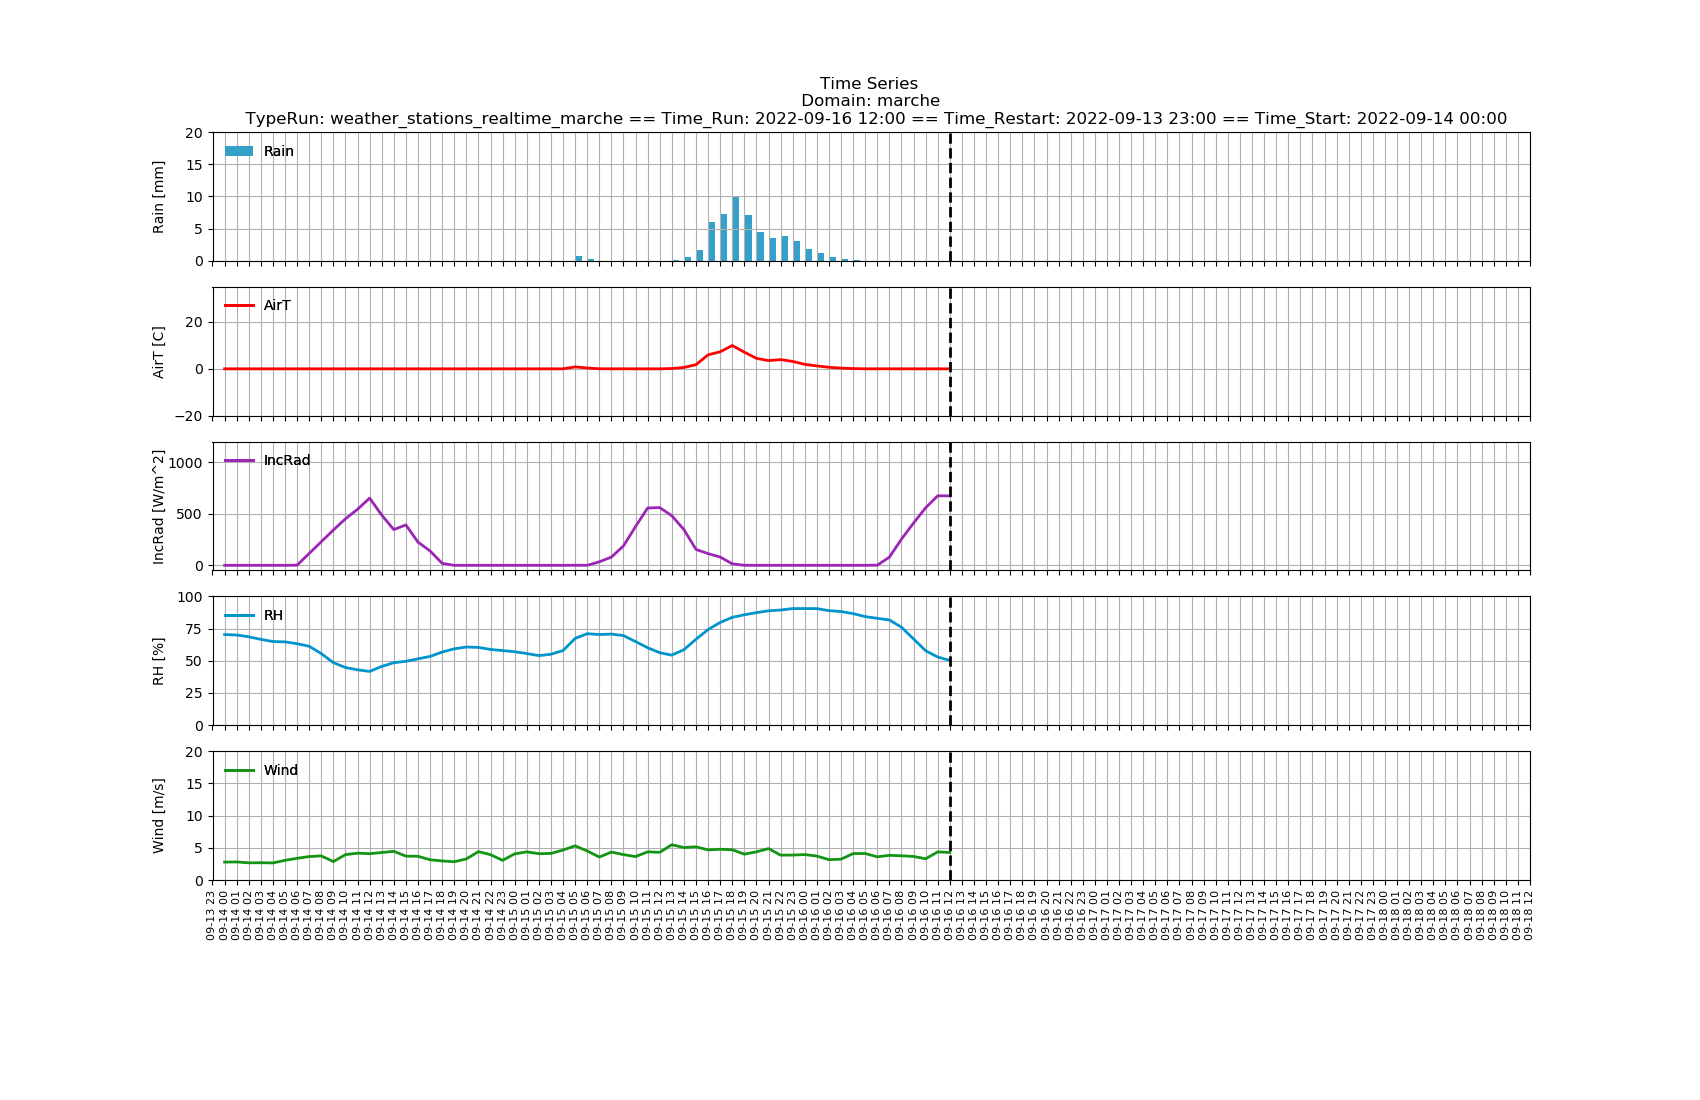

In [51]:
# Plot domain average forcing datasets
workspace_check = check_ts_workspace(
    [dframe_domain_forcing_period],
    ['attributes'], variable_dataset='domain_forcing')
if workspace_check:

    run_file_path_destination_plot = file_path_dset_dynamic_destination_plot_domain['weather_stations']
    run_file_path_destination_plot = wrap_file(
        run_file_path_destination_plot, file_mode=info_mode,
        file_root_default=file_root_path, file_folder_default='plot', file_nullify=False)
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... ')
    
    plot_ts_forcing_obs(
        run_file_path_destination_plot,
        dframe_domain_forcing_period.attrs,
        df_rain=ts_rain_forcing_period,
        df_airt=ts_air_temperature_forcing_period,
        df_incrad=ts_incoming_radiation_forcing_period,
        df_rh=ts_relative_humidity_forcing_period,
        df_winds=ts_wind_speed_forcing_period,
    )
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... DONE')
    

#### Plot section location

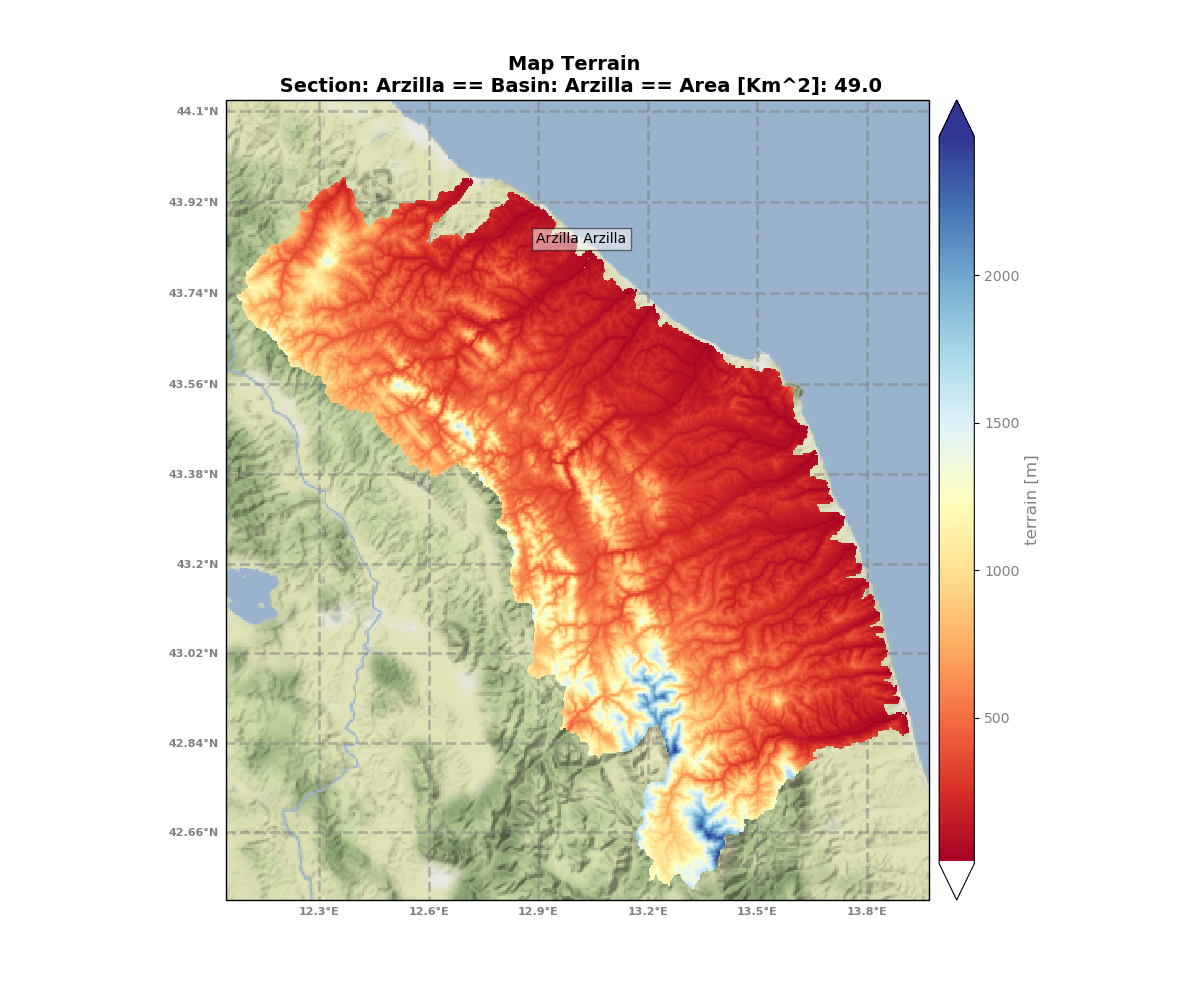

In [52]:
# PLOT SECTION LOCATOR
plot_map_terrain(
    None,
    darray_terrain, darray_river_network, info_section_attrs,
    mask_terrain=False
)

#### Plot weather stations run

 INFO ---> Check the time series workspace for the "weather_stations" ... 
 INFO ---> Check the time series workspace for the "weather_stations" ... DONE
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.weather_stations.Arzilla_Arzilla.202209150700.png" ... 
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.weather_stations.Arzilla_Arzilla.202209150700.png" ... DONE


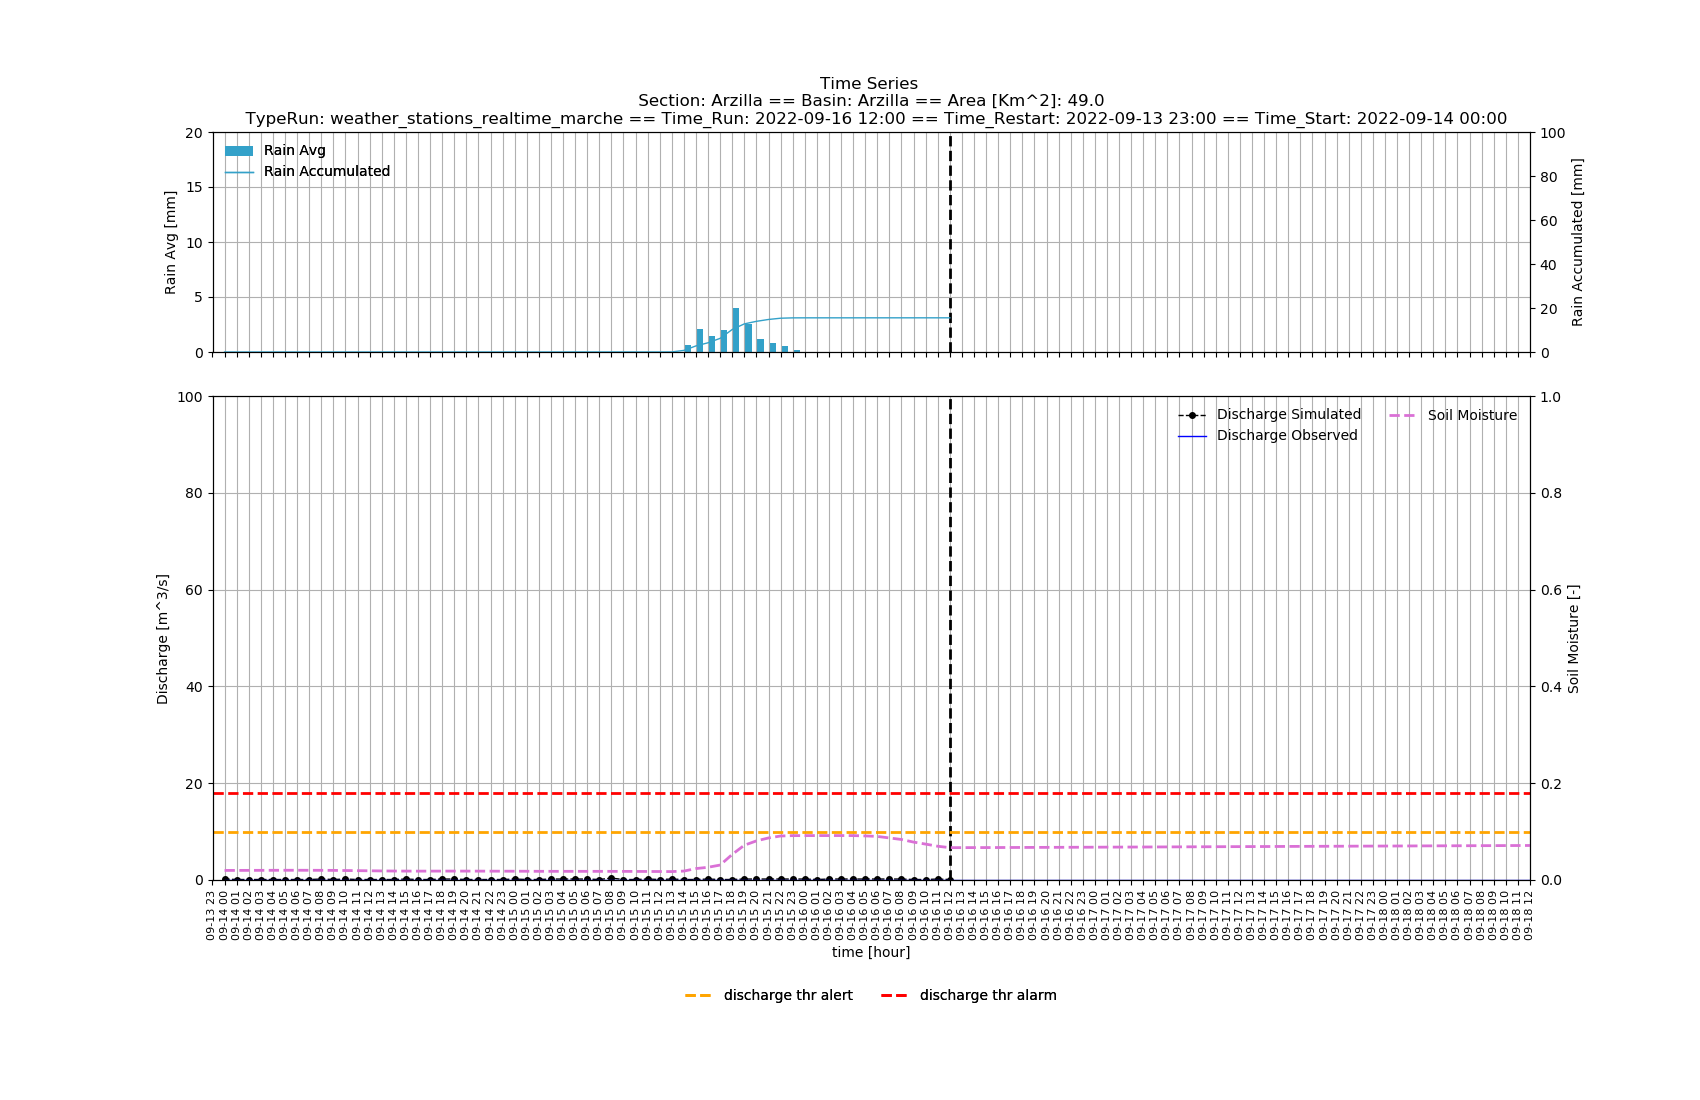

In [53]:
# PLOT WEATHER STATION OBS
workspace_check = check_ts_workspace(
    [dframe_ws_period],
    ['attributes'], variable_dataset='weather_stations')
if workspace_check:

    run_file_path_destination_plot = file_path_dset_dynamic_destination_plot_section['weather_stations']
    run_file_path_destination_plot = wrap_file(
        run_file_path_destination_plot, file_mode=info_mode,
        file_root_default=file_root_path, file_folder_default='plot', file_nullify=False)
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... ')
    
    plot_ts_discharge_obs(
        run_file_path_destination_plot,
        dframe_ws_period.attrs,
        ts_rain_ws_period,
        ts_discharge_simulated_ws_period,
        ts_sm_ws_period,
        ts_discharge_observed_ws_period
    );
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... DONE')

#### Plot nwp lami-2i deterministic run

 INFO ---> Check the time series workspace for the "nwp_lami-2i_deterministic" ... 
 INFO ---> Check the time series workspace for the "nwp_lami-2i_deterministic" ... DONE
 INFO ---> Check the time series workspace for the "nwp_lami-2i_deterministic" ... DONE
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_lami2i_deterministic.Arzilla_Arzilla.202209150700.png" ... 
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_lami2i_deterministic.Arzilla_Arzilla.202209150700.png" ... DONE


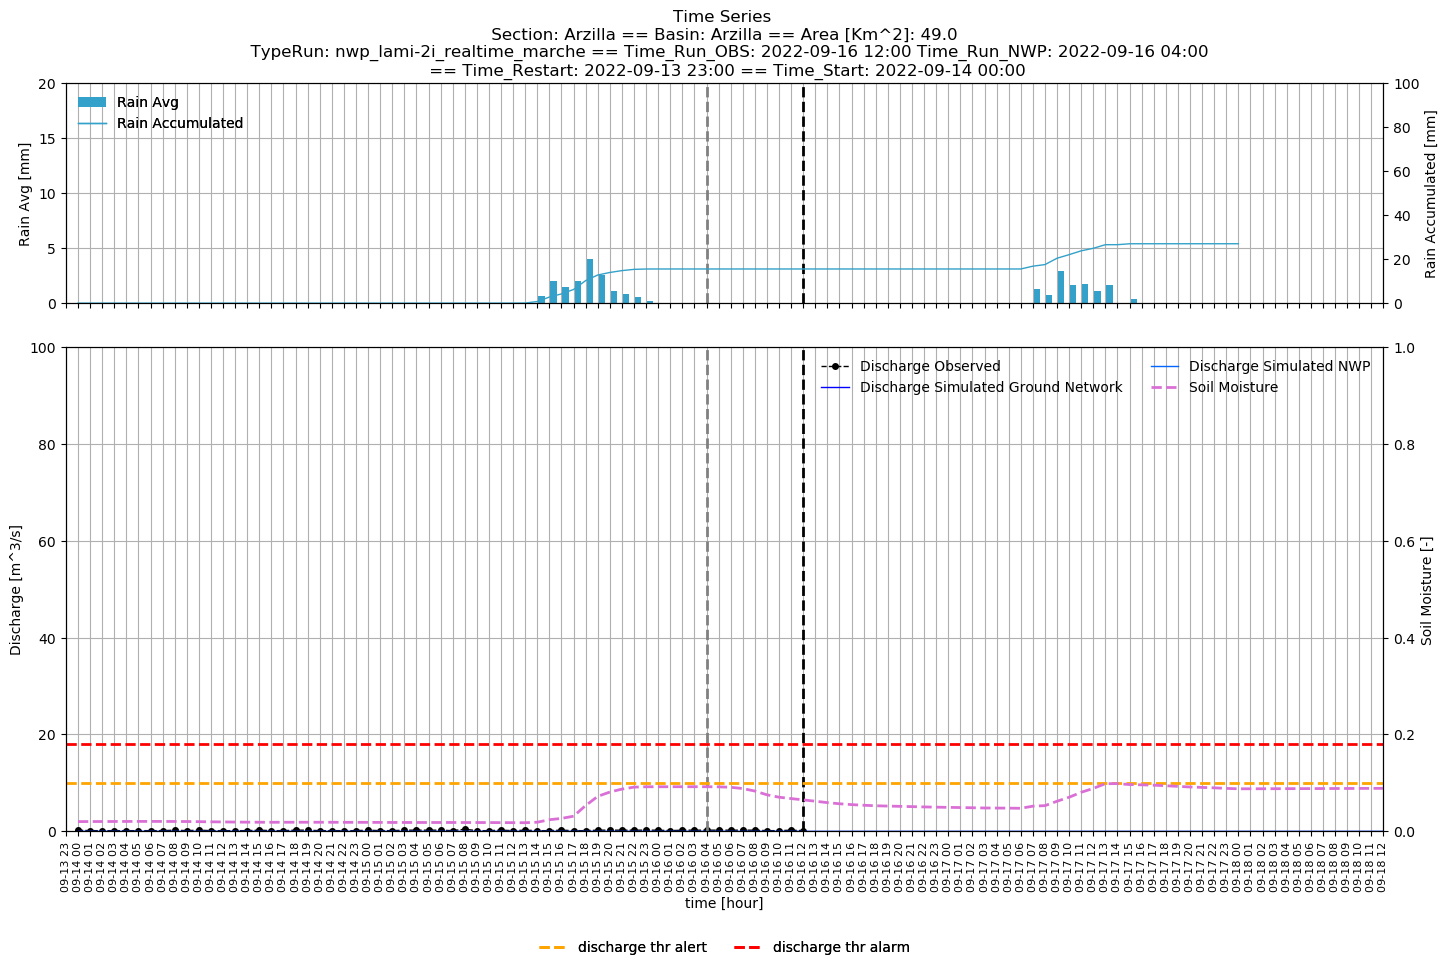

In [54]:
# PLOT DETERMINISTIC LAMI-2I
%matplotlib inline
workspace_check = check_ts_workspace(
    [dframe_ws_period, dframe_nwp_lami2i_det_period],
    ['attributes', 'attributes'], variable_dataset='nwp_lami-2i_deterministic')
if workspace_check:

    run_file_path_destination_plot = file_path_dset_dynamic_destination_plot_section['nwp_deterministic_lami2i']
    run_file_path_destination_plot = wrap_file(
        run_file_path_destination_plot, file_mode=info_mode,
        file_root_default=file_root_path, file_folder_default='plot', file_nullify=False)
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... ')
    
    plot_ts_discharge_nwp_deterministic(
        run_file_path_destination_plot,
        dframe_ws_period.attrs,
        dframe_nwp_lami2i_det_period.attrs,
        ts_rain_ws_period,
        ts_rain_nwp_lami2i_det_period,
        ts_discharge_simulated_ws_period,
        ts_discharge_simulated_nwp_lami2i_det_period,
        ts_sm_ws_period,
        ts_sm_nwp_lami2i_det_period,
        ts_discharge_observed_ws_period
    )
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... DONE')

#### Plot nwp lami-2i probabilistic run

 INFO ---> Check the time series workspace for the "nwp_lami-2i_probabilistic" ... 
 INFO ---> Check the time series workspace for the "nwp_lami-2i_probabilistic" ... DONE
 INFO ---> Check the time series workspace for the "nwp_lami-2i_probabilistic" ... DONE
 INFO ---> Check the time series workspace for the "nwp_lami-2i_probabilistic" ... DONE
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_lami2i_probabilistic.Arzilla_Arzilla.202209150700.png" ... 


/home/fabio/fp_system_conda/envs/fp_system_conda_jupyter_labs_libraries/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/fabio/Documents/Work_Area/Code_Development/Workspace/PyCharm_Notebook/fp-labs-hmc-master/library/common/lib_graph_ts_utils.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe_variable_ensemble[variable_qtls_name + str(variable_qtls)] = dframe_variable_qtls.values[variable_id]


 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_lami2i_probabilistic.Arzilla_Arzilla.202209150700.png" ... DONE


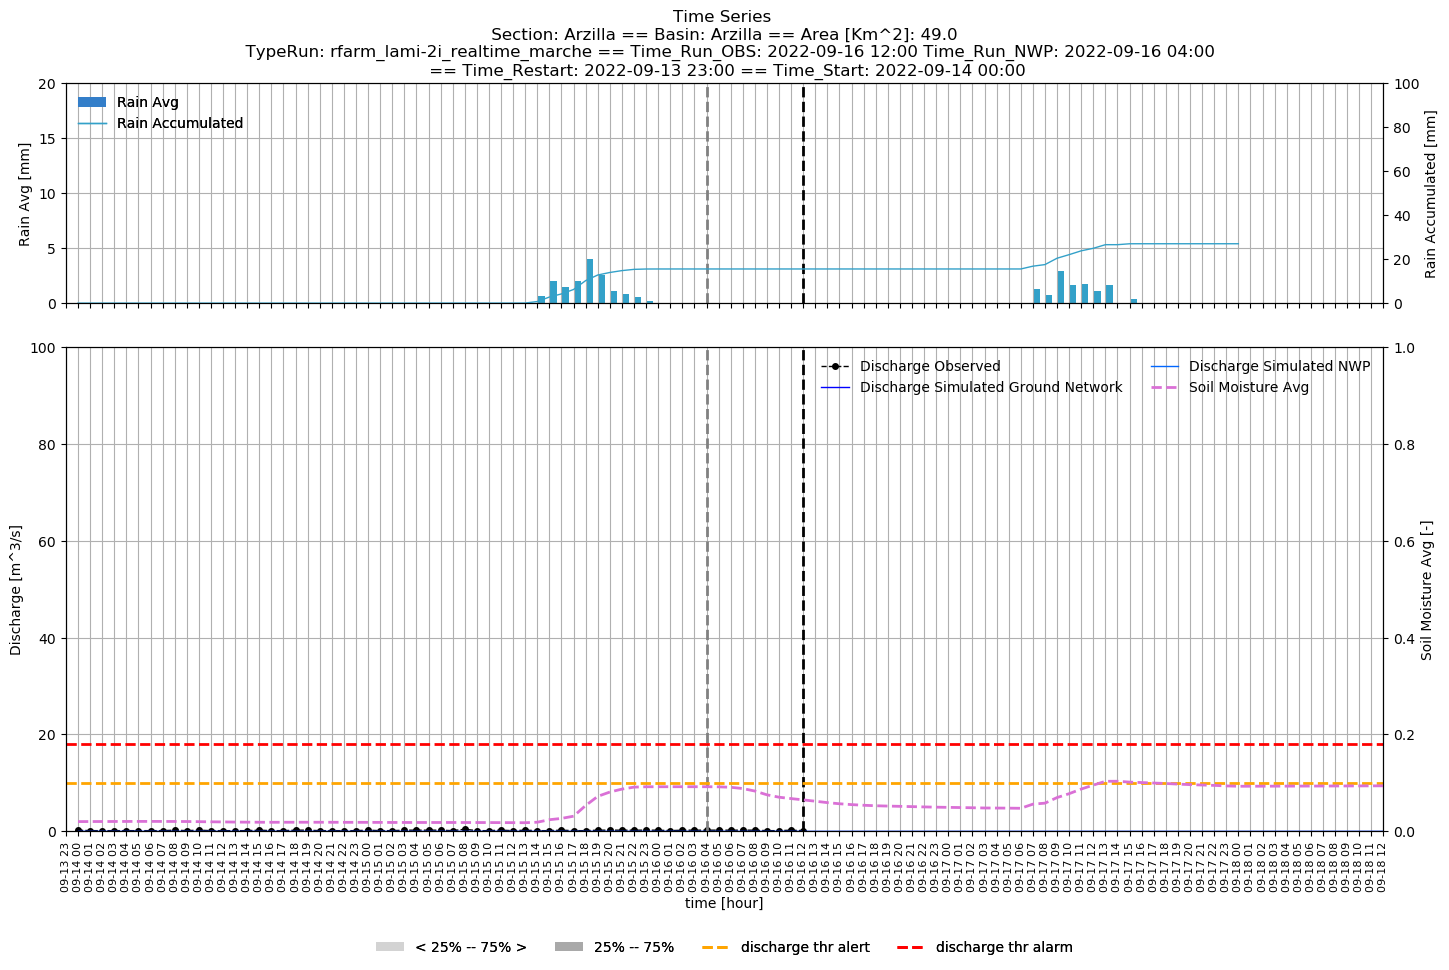

In [55]:
# PLOT PROBABILISTIC LAMI-2I
%matplotlib inline
workspace_check = check_ts_workspace(
    [dframe_ws_period, dframe_nwp_lami2i_det_period, dframe_nwp_lami2i_prob_period],
    ['attributes', 'attributes', 'attributes'], variable_dataset='nwp_lami-2i_probabilistic')
if workspace_check:

    run_file_path_destination_plot = file_path_dset_dynamic_destination_plot_section['nwp_probabilistic_lami2i']
    run_file_path_destination_plot = wrap_file(
        run_file_path_destination_plot, file_mode=info_mode,
        file_root_default=file_root_path, file_folder_default='plot', file_nullify=False)
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... ')
    
    plot_ts_discharge_nwp_probabilistic(
        run_file_path_destination_plot,
        dframe_ws_period.attrs,
        dframe_nwp_lami2i_det_period.attrs, dframe_nwp_lami2i_prob_period.attrs,
        ts_rain_ws_period,
        ts_rain_nwp_lami2i_det_period, ts_rain_nwp_lami2i_prob_period,
        ts_discharge_simulated_ws_period,
        ts_discharge_simulated_nwp_lami2i_det_period, ts_discharge_simulated_nwp_lami2i_prob_period,
        ts_sm_ws_period,
        ts_sm_nwp_lami2i_det_period, ts_sm_nwp_lami2i_prob_period,
        ts_discharge_observed_ws_period
    )
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... DONE')

#### Plot nwp ecmwf0100 deterministic run

 INFO ---> Check the time series workspace for the "nwp_ecmwf0100_deterministic" ... 
 INFO ---> Check the time series workspace for the "nwp_ecmwf0100_deterministic" ... DONE
 INFO ---> Check the time series workspace for the "nwp_ecmwf0100_deterministic" ... DONE
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_ecmwf0100_deterministic.Arzilla_Arzilla.202209150700.png" ... 
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_ecmwf0100_deterministic.Arzilla_Arzilla.202209150700.png" ... DONE


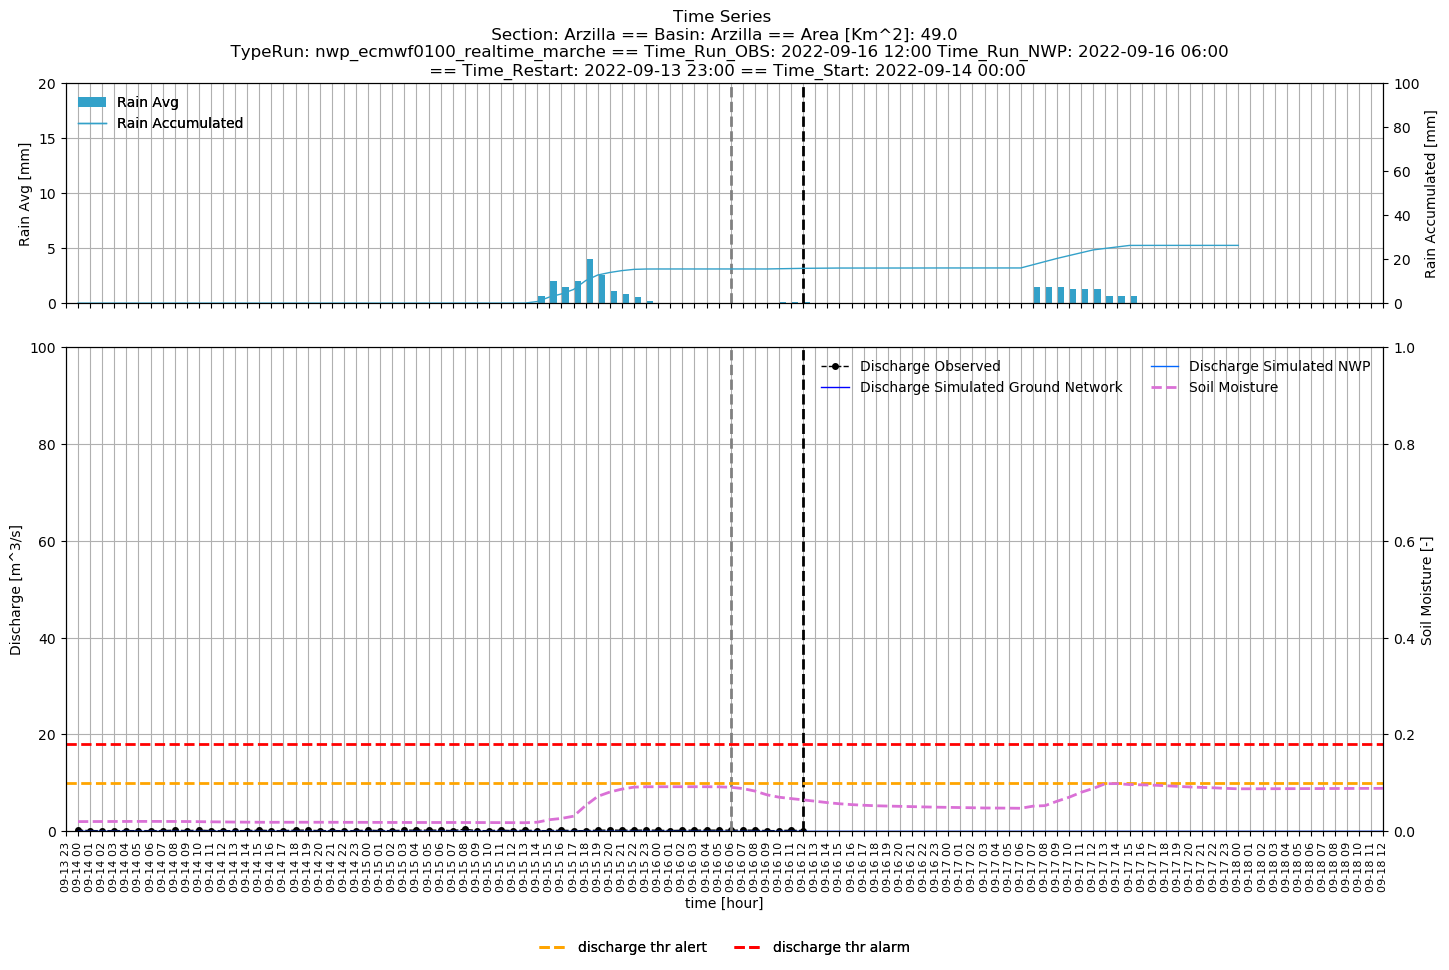

In [56]:
# PLOT DETERMINISTIC ECMWF0100
workspace_check = check_ts_workspace(
    [dframe_ws_period, dframe_nwp_ecmwf0100_det_period],
    ['attributes', 'attributes'], variable_dataset='nwp_ecmwf0100_deterministic')
if workspace_check:

    run_file_path_destination_plot = file_path_dset_dynamic_destination_plot_section['nwp_deterministic_ecmwf0100']
    run_file_path_destination_plot = wrap_file(
        run_file_path_destination_plot, file_mode=info_mode,
        file_root_default=file_root_path, file_folder_default='plot')
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... ')
    
    plot_ts_discharge_nwp_deterministic(
        run_file_path_destination_plot,
        dframe_ws_period.attrs,
        dframe_nwp_ecmwf0100_det_period.attrs,
        ts_rain_ws_period,
        ts_rain_nwp_ecmwf0100_det_period,
        ts_discharge_simulated_ws_period,
        ts_discharge_simulated_nwp_ecmwf0100_det_period,
        ts_sm_ws_period,
        ts_sm_nwp_lami2i_det_period,
        ts_discharge_observed_ws_period
    )
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... DONE')

#### Plot nwp ecmwf0100 probabilistic run

 INFO ---> Check the time series workspace for the "nwp_ecmwf0100_probabilistic" ... 
 INFO ---> Check the time series workspace for the "nwp_ecmwf0100_probabilistic" ... DONE
 INFO ---> Check the time series workspace for the "nwp_ecmwf0100_probabilistic" ... DONE
 INFO ---> Check the time series workspace for the "nwp_ecmwf0100_probabilistic" ... DONE
 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_ecmwf0100_probabilistic.Arzilla_Arzilla.202209150700.png" ... 


/home/fabio/fp_system_conda/envs/fp_system_conda_jupyter_labs_libraries/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/fabio/Documents/Work_Area/Code_Development/Workspace/PyCharm_Notebook/fp-labs-hmc-master/library/common/lib_graph_ts_utils.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe_variable_ensemble[variable_qtls_name + str(variable_qtls)] = dframe_variable_qtls.values[variable_id]


 ==> Save plot to : "/home/fabio/fp_labs_datasets/images/time_series/20220915_07/hmc.nwp_ecmwf0100_probabilistic.Arzilla_Arzilla.202209150700.png" ... DONE


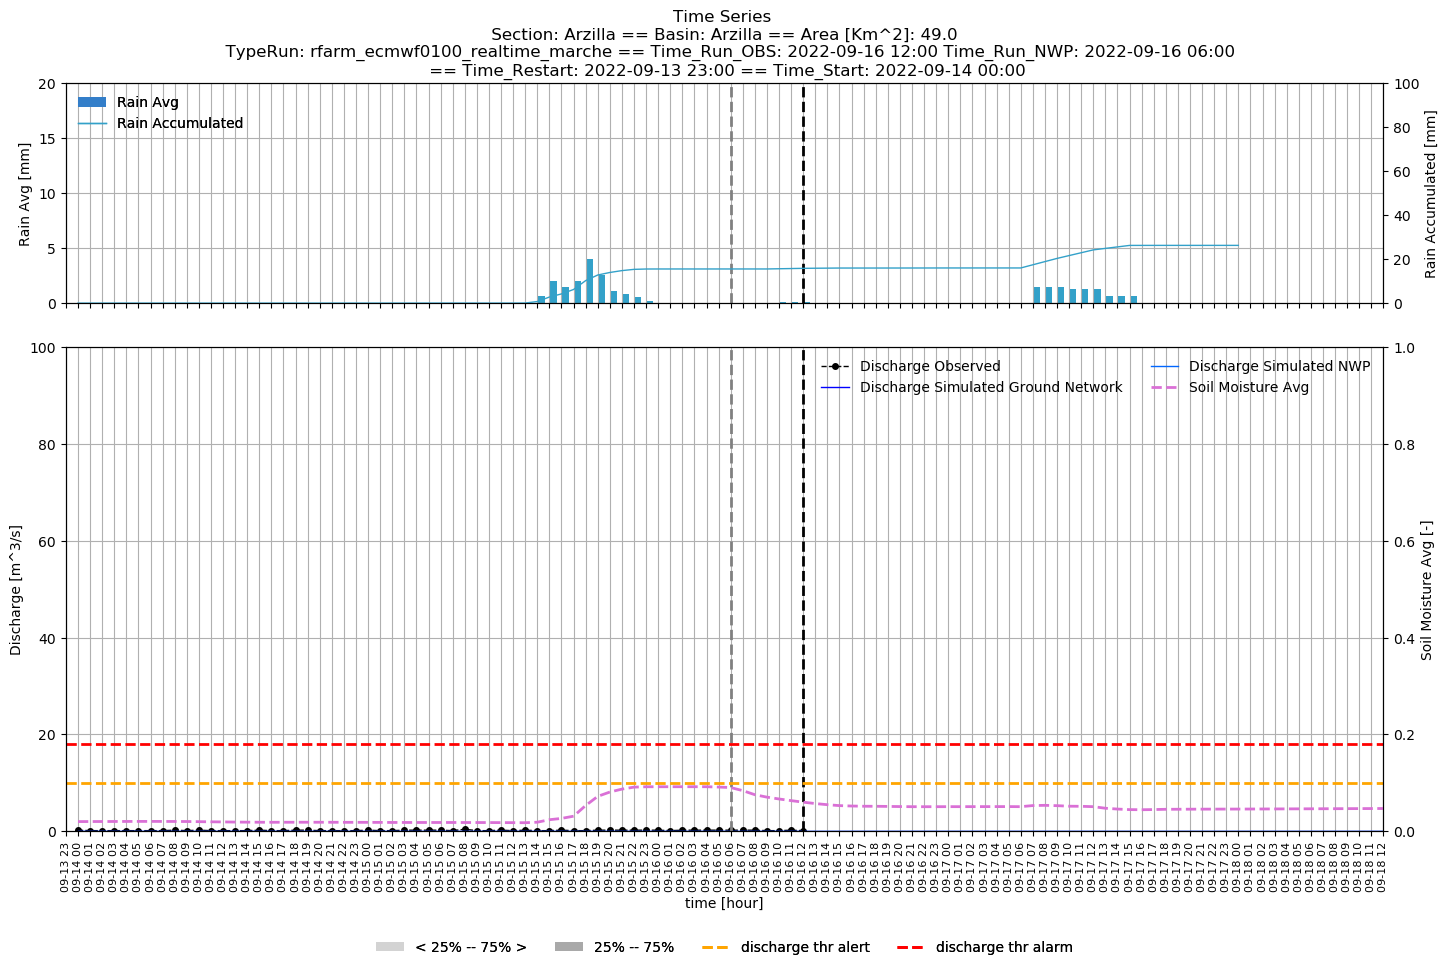

In [57]:
# PLOT PROBABILISTIC ECMWF-0100
workspace_check = check_ts_workspace(
    [dframe_ws_period, dframe_nwp_ecmwf0100_det_period, dframe_nwp_ecmwf0100_prob_period],
    ['attributes', 'attributes', 'attributes'], variable_dataset='nwp_ecmwf0100_probabilistic')
if workspace_check:

    run_file_path_destination_plot = file_path_dset_dynamic_destination_plot_section['nwp_probabilistic_ecmwf0100']
    run_file_path_destination_plot = wrap_file(
        run_file_path_destination_plot, file_mode=info_mode,
        file_root_default=file_root_path, file_folder_default='plot')
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... ')
    
    plot_ts_discharge_nwp_probabilistic(
        run_file_path_destination_plot,
        dframe_ws_period.attrs,
        dframe_nwp_ecmwf0100_det_period.attrs, dframe_nwp_ecmwf0100_prob_period.attrs,
        ts_rain_ws_period,
        ts_rain_nwp_ecmwf0100_det_period, ts_rain_nwp_ecmwf0100_prob_period,
        ts_discharge_simulated_ws_period,
        ts_discharge_simulated_nwp_ecmwf0100_det_period, ts_discharge_simulated_nwp_ecmwf0100_prob_period,
        ts_sm_ws_period,
        ts_sm_nwp_ecmwf0100_det_period, ts_sm_nwp_ecmwf0100_prob_period,
        ts_discharge_observed_ws_period
    )
    
    print(' ==> Save plot to : "' + run_file_path_destination_plot + '" ... DONE')

**Training on-the-job**
- Download/Organize the static and dynamic datasets for a different "time run";
- Select a different case-study (time run);
- Select a different outlet section (section name, basin name);
- Add/change the variables in the time-series plot (have to check the names of the variables in the netcdf forcing or outcome files);
- Add/change the plot of terrain datasets (for example using a different map background);
- Try to write your notebook using a new case-study using only a couple of run type;
- ...